# Laboratorio 2 Redes Neuronales

##### Profesor: Gonzalo Acuña
##### Ayudante: Ignacio Ibañez
##### Alumno: Dany Rubiano 

## LSTM

LSTM es una arquitectura de red neuronal recurrente diseñada originalmente para el aprendizaje de series de tiempo supervisadas. Se basa en un análisis de los problemas que los algoritmos recurrentes de aprendizaje de redes neuronales tienen al aprender series temporales con dependencias a largo plazo, en los que los errores propagados en el tiempo tienden a desaparecer o explotar.
La solución de LSTM a este problema es imponer un flujo de error constante en varias unidades especializadas, denominadas carruseles de error constante (CEC) a través funciones de activación lineal que no decaen con el tiempo. Tanto el acceso de información a los CEC como su acceso desde las activaciones a las unidades de salida, son reguladas mediante compuertas de entrada y salida, las cuales reciben información de las series de tiempo y otras unidades de la red, con la que aprenden a abrir y cerrar el acceso a los CEC, y la salida de su información almacenada en los momentos apropiados. Una adición reciente son las compuertas de olvido, que aprenden a restablecer la activación de los CEC cuando la información que almacenan ya no es útil. La combinación de un CEC con su entrada asociada, salida y puerta de olvido se llama celda de memoria. La combinación de múltiples CEC con una sola entrada, salida y puerta de olvido, se  denomina bloque de memoria.

Para el aprendizaje, en algunas o todas las etapas de tiempo de las series de tiempo, las unidades de salida de la red pueden cometer errores de predicción. Los errores se propagan sólo un paso atrás en el tiempo a través de todas las unidades que no sean los CEC, incluidas las puertas. Sin embargo, los errores se propagan de nuevo a través de los CEC durante un período de tiempo indefinido, utilizando una variación eficiente de RTRL. Las actualizaciones de peso se realizan a cada paso del tiempo (Bakker, 2003).

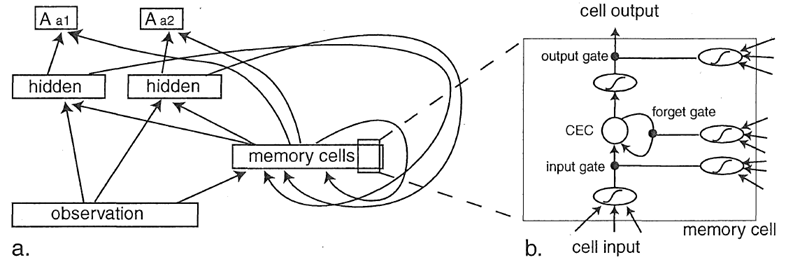
Figura 1: a. Arquitectura LSTM. Las flechas indican pesos unidireccionales. Las unidades de salida de la red codifican directamente el Avantage de diferentes acciones. b. Una celda de memoria.


In [10]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy
from scipy import stats
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import losses
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def cross_validation(values, percentage, n_lags, n_features):
    # split into train and test sets
    train_size = int(len(values) * percentage)
    test_size = len(values) - train_size
    train, test = values[0:train_size,:], values[train_size:len(values),:]
    
    # split into input and outputs
    n_obs = n_lags * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_lags, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_lags, n_features))

    return train_X, train_y, test_X, test_y

def lstm(train_X, train_y, test_X, test_y, activation_f, loss_f, optimizer_f, n_epochs, n_batch, n_units, n_lags, n_features, show):
    # design network
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1, activation = activation_f))
    model.compile(loss = loss_f, optimizer = optimizer_f)
    # fit network
    history = model.fit(train_X, train_y, epochs=n_epochs, validation_data=(test_X, test_y), batch_size=n_batch, verbose=0, shuffle=False)
    
    if (show == 1):
        #print(model.summary())
    
        plt.plot(history.history['loss'], 'b.',label='train')
        plt.grid()
        plt.title('Error vs Iteraciones')
        plt.xlabel('Iteraciones')
        plt.ylabel(loss_f)
        plt.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_lags*n_features))
    
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    correlation = stats.pearsonr(inv_y, inv_yhat)
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

    return inv_yhat, inv_y, correlation, rmse

def plot_prediction(inv_yhat, inv_y, train_y, data, n):
    plt.plot(inv_y)
    plt.plot(inv_yhat)
    plt.show()

    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(data[:,0])
    trainPredictPlot[0:len(train_y)] = numpy.nan
    trainPredictPlot[len(train_y):n] = inv_y

    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(data[:,0])
    testPredictPlot[0:len(train_y)] = numpy.nan
    testPredictPlot[len(train_y):n] = inv_yhat
    
    plt.plot(data[:,0], label = 'Real')
    plt.plot(testPredictPlot, 'r', label = 'Predicho')
    plt.axis([n-2*len(inv_yhat),n,55,80])
    plt.legend()
    plt.grid()
    plt.title('Velocidad del flujo sanguíneo Cerebral')
    plt.xlabel('N')
    plt.ylabel('VFSC')
    plt.show()


## Dataset
La autorregulación de la circulación cerebral permite mantener un flujo sanguíneo cerebral constante a pesar de cambios de la presión arterial sistémica. Entre el 15 y 25% del gasto cardíaco está dirigido al cerebro, con un FSC de 40-50 mL/100g de tejido cerebral/min. El FSC está determinado por el consumo metabólico de oxígeno cerebral (CMRO2), influida por la autorregulación mediante la resistencia vascular cerebral (RVC), y por la presión de perfusión cerebral (PPC) (Díaz, 2015).

Para mantener un FSC constante ante variaciones de la PAM deben realizarse cambios en la RVC (estos cambios se van a producir en los vasos cerebrales de menor calibre o microcirculación: esfínteres precapilares y arteriolas de pequeño calibre). De este modo, el FSC se mantiene constante en situaciones fisiológicas a pesar de importantes cambios en la PAM (en un rango entre 50-150mmHg). Así, al bajar la PAM se produce vasodilatación a nivel de la microcirculación, evitando la consecuente isquemia; mientras que si sube la PAM, se produce vasoconstricción, evitando la hiperperfusión (Fundación, 2014).

Para el presente estudio, se entiende por normocapnia cuando la respuesta autorregulatoria del FSC de un sujeto es “normal” ante una alteración de la PAM producida por el aumento de dióxido de carbono (CO2) en la sangre. En contraparte, se entiende por hipercapnia cuando la respuesta autorregulatoria es ineficiente.

Finalmente como dataset se elige un paciente que presenta hipercapnia.

In [11]:
# load dataset
dataset = read_csv('HC090161.PAR', engine='python', sep='\s+', usecols=[1,2])
data = dataset.values

# ensure all data is float
data = data.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)


# specify the number of lag hours
n_lags = 3 #retardos
n_features = 2 #parametros (2: VFSC, PAM)

## Prueba con diferentes conguraciones de la LSTM

Buscando encontrar el mejor modelo para la LSTM y la experimentación con el conjunto de datos seleccionado, se realiza una grilla de parámetros variando desde la función de activación, la función de objetivo, cantidad de iteraciones, entre otros parámetros que se detalla a continuación:
    1. Función de activación  
       - Softplus, log(exp(x) + 1)
       - Relu, x if x > 0, alpha * x if x < 0
    2. Función de objetivo
       - Mean squared error
       - Logcosh, log(cosh(x))
    3. Función de optimización
       - RMSprop, optimizador que utiliza la magnitud de gradientes recientes para normalizar los degradados.
       - Nadam, optimizador basado en RMSprop pero con impulso de Nesterov.
    4. Número de retardos de PAM
       Para el número de retardos se realizó una variación entre 1, 3, 5 y 7 retaardos. 
       Más retardos no se justifican, buscando cumplir con el principio de parsimonia.
    5. Cantidad de iteraciones
       Se utilizan 20, 30, 50 y 100 iteraciones.
    6. Cantidad de neuronas
       Se utilizan 50 y 100 neuronas

In [ ]:
# Grilla de parametros

retardos = [1,3,5,7]
iteraciones = [20,30,50,100]
loss_f = ['mean_squared_error','logcosh',]
activation_f = ['softplus','relu']
optimizer_f = ['RMSprop','Nadam']
results = []


for n in range(0,4):
    # frame as supervised learning 
    reframed = series_to_supervised(scaled, retardos[n], 1)
    #print(reframed.shape)
    #print(reframed.head())

    #split into train and test sets
    values = reframed.values

    for i in range(0,4):
        for j in range(0,2):
            for k in range(0,2):
                for l in range(0,2): 
                    train_X, train_y, test_X, test_y = cross_validation(values, 0.7, retardos[n], n_features)
                    inv_yhat, inv_y, correlation, error = lstm(train_X, train_y, test_X, test_y, activation_f[k], loss_f[j], optimizer_f[l], iteraciones[i], 32, 50, retardos[n], n_features, 0)
                    parametros = [retardos[n], iteraciones[i], loss_f[j], activation_f[k], optimizer_f[l], correlation, error]
                    print(parametros)
                    results.append(parametros)
#print(results)

## Pruebas en validación cruzada

Del código anterior se obtienen 4 modelos a los que se le aplican pruebas en validación cruzada, variando el tamaño del conjunto de entrenamiento y prueba.

In [ ]:
# Mejores modelos
# Combianción con validacion cruzada
#[1, 100, 'logcosh', 'softplus', 'Nadam', (0.9880004, 0.0), 0.5414956782741805]
#[3, 100, 'logcosh', 'relu', 'Nadam', (0.9928865, 0.0), 0.4204014368515432] ***
#[5, 100, 'mean_squared_error', 'relu', 'RMSprop', (0.9952182, 0.0), 0.7330918566536534] ***
#[7, 100, 'mean_squared_error', 'relu', 'RMSprop', (0.9967415, 0.0), 0.5754490084010573] ***

parameters = [[1,100,'logcosh','softplus','Nadam'],[3,100,'logcosh','relu','Nadam'],[5,100,'mean_squared_error','relu','RMSprop'],[7, 100, 'mean_squared_error', 'relu','RMSprop']]
results_c = []

for i in range(1,10):
    percentage = (10-i)/10

    for j in range(0,4):
        reframed = series_to_supervised(scaled, parameters[j][0], 1)
        values = reframed.values
        train_X, train_y, test_X, test_y = cross_validation(values, percentage, parameters[j][0], n_features)
        inv_yhat, inv_y, correlation, error = lstm(train_X, train_y, test_X, test_y, parameters[j][3], parameters[j][2], parameters[j][4], parameters[j][1], 32, 50, parameters[j][0], n_features,0)
        params = [parameters[j][0], parameters[j][1], parameters[j][2], parameters[j][3],parameters[j][4], percentage, correlation, error]
        print(params)
        results_c.append(params)

#print(result_c)


## Mejores modelos

A partir de las configuraciones de los parámetros de la LSTM y las pruebas con validación cruzada se escogen los modelos que se detallan a continuación.
Todos se caracterizan por utilizar 100 iteraciones y tener una correlación de 0.99 entre la función real y predecida.

Train:  0.8 Test:  0.2
Retrasos:  5
Iteraciones:  100
Funcion de Activacion:  relu
Funcion de Objetivo:  mean_squared_error
Funcion de Optimizacion:  RMSprop


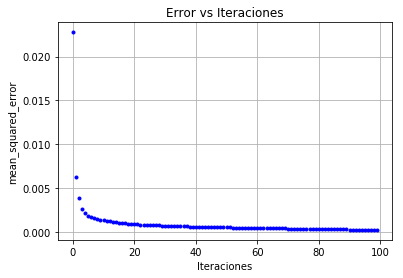

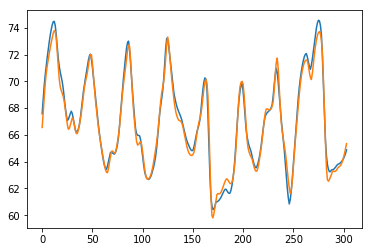

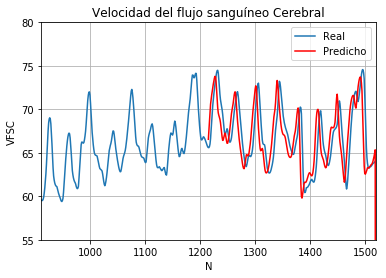

Correlación de Pearson (cor, p-value):  (0.9920426, 7.508551035602586e-274)
Error RMSE:  0.49361962154314726



Train:  0.7 Test:  0.3
Retrasos:  3
Iteraciones:  100
Funcion de Activacion:  relu
Funcion de Objetivo:  logcosh
Funcion de Optimizacion:  Nadam


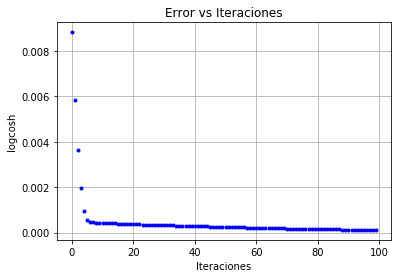

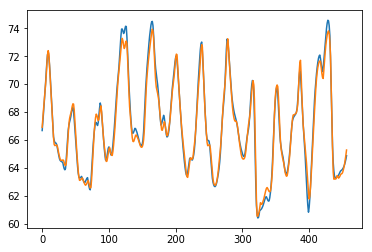

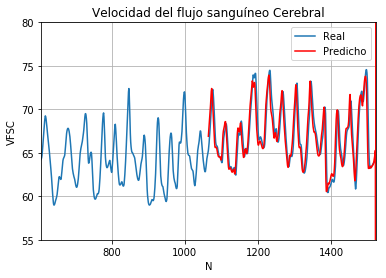

Correlación de Pearson (cor, p-value):  (0.9932364, 0.0)
Error RMSE:  0.43329144154615645



Train:  0.7 Test:  0.3
Retrasos:  7
Iteraciones:  100
Funcion de Activacion:  relu
Funcion de Objetivo:  mean_squared_error
Funcion de Optimizacion:  RMSprop


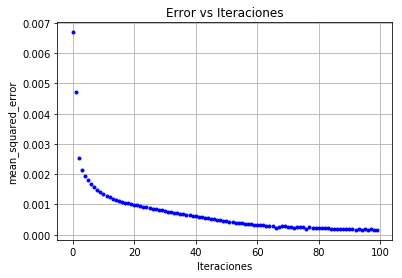

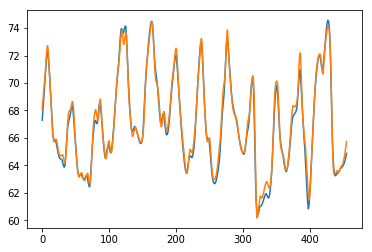

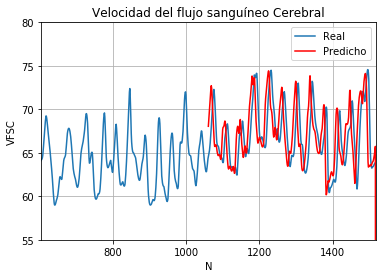

Correlación de Pearson (cor, p-value):  (0.9943398, 0.0)
Error RMSE:  0.404443870764251





In [12]:
# Mejores modelos

#[5, 100, 'mean_squared_error', 'relu', 'RMSprop', 0.8, (0.9943227, 6.432267464342518e-296), 0.5764735579700384]***
#[3, 100, 'logcosh', 'relu', 'Nadam', 0.7, (0.99390954, 0.0), 0.402240443624113] ***
#[7, 100, 'mean_squared_error', 'relu', 'RMSprop', 0.7, (0.99538934, 0.0), 0.9271442664763587] ***

finals = [[5, 100, 'mean_squared_error', 'relu', 'RMSprop', 0.8],[3, 100, 'logcosh', 'relu', 'Nadam', 0.7],[7, 100, 'mean_squared_error', 'relu', 'RMSprop', 0.7]]

for i in range(0,3):
    # frame as supervised learning 
    reframed = series_to_supervised(scaled, finals[i][0], 1)
    #split into train and test sets
    values = reframed.values
    print('Train: ',finals[i][5],'Test: ',numpy.around(1-finals[i][5], decimals=1))
    print('Retrasos: ',finals[i][0])
    train_X, train_y, test_X, test_y = cross_validation(values, finals[i][5], finals[i][0], n_features)
    print('Iteraciones: ',finals[i][1])
    print('Funcion de Activacion: ',finals[i][3])
    print('Funcion de Objetivo: ',finals[i][2])
    print('Funcion de Optimizacion: ',finals[i][4])
    inv_yhat, inv_y, correlation, error = lstm(train_X, train_y, test_X, test_y, finals[i][3], finals[i][2], finals[i][4], finals[i][1], 32, 50, finals[i][0], n_features,1)
    plot_prediction(inv_yhat, inv_y, train_y, data, len(values))
    print('Correlación de Pearson (cor, p-value): ', correlation)
    print('Error RMSE: ',error)
    print('\n\n')

## Análisis de Resultados

Al iniciar el análisis de la experimentación, se evidencia que la LSTM tiene muy buenos resultados aún cuando se utilizan pocas iteraciones y sólo un retraso, de tal forma que la correlación entre la función predecida y la función real, es mayor a 0.8. Esto puede deberse al potencial de las LSTM de trabajar con series de tiempo a través de sus compuertas de entrada, salida y olvido para conservar el error necesario para el aprendizaje y poder tratar con las dependecias temporales a largo plazo.

Se obtienen 3 modelos cuya correlación alcanza 0.9, utilizando distintos 3, 5 y 7 retardos en el tiempo de la PAM, para la predicción del VFSC. Estos se escogieron una vez hecha la grilla de parámetros y la validación cruzada. Se optó por considerar aquellos modelos que presentaban una mayor correlación, omitiendo el principio de parsimonia, al no optar por aquellos modelos con menor complejidad, tanto en los retardos considerados, como en la cantidad de neuronas y la cantidad de iteraciones.
Por otro lado, todos los modelos convergían entre sus iteraciones a un error bajo 10^-4, necesitando para ello alrededor de 50 iteraciones.

Se destaca que las funciones de optimización, en combinación con la validación con el conjunto de prueba del modelo, mejoran significativamente los resultados para alcanzar la correlación que aquí se presenta.



## Conclusiones

Una vez concluida la experiencia, se puede afirmar que se pudo llevar a cabo exitosamente la implementación de una red recurrente LSTM con el uso de la biblioteca keras y sus funciones disponibles. Se destaca la versatilidad y facilidad que presta dicha biblioteca para el desarrollo de este tipo de redes y muchas otras que podrían ser consideradas.
De la misma forma se pudo experimentar con algunas funciones de activación y funciones de objetivo no consideradas en la experiencia anterior, además de la consideración de algunas funciones de optimización tales como RMSprop y Nadam que ayudan a mejorar el rendimiento de los modelos implementados.

Se destaca así mismo el poder que presenta las redes LSTM para trabajar con series de tiempo, en esta ocasión bajo el enfoque de la predicción, de tal forma que la implementación realizada alcanza una muy alta correlación entre la función real y lo que la red predice.

En general esta experiencia ha sido de gran utilidad para tener un acercamiento a las redes neuronales recurrentes, en especial teniendo en cuenta que para mi trabajo de memoria, utilizaré una red recurrente en conjunto con una red convolucional para implementar una arquitectura para la clasificación de series de tiempo.

## Bibliografía
B. Bakker (2003). Reinforcement Learning with Long Short-Term Memory

Díaz M., & Carrillo, R. (2015). Flujo sanguíneo cerebral.

Fundación para la formación e Investigación sanitarias de la región de Murcia. (2014). Circulación y vasorregulación cerebral. URL http://www.ffis.es/volviendoalobasico/3circulacin_y_vasorregulacin_cerebral.html

